# Image Sequence Generator for npy Samples

In [1]:
working_dir = "/Volumes/Samsung_T5/WeatherNet_V2"
npy_dir = working_dir + "/npy_dataset"
weather_dir = npy_dir + "/weather/15_min"

 ## Import Modules

In [2]:
# General 
import os
from tqdm import trange

# Data manipulation
from PIL import Image
import pandas as pd
import glob 

# Numeric operations 
import numpy as np 
from random import shuffle 
from itertools import chain 

# Data Generator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical 

# Plotting 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

## Declare Paths to Data

In [3]:
flir_path = npy_dir + "/flir"
top_path = npy_dir + "/top"
bottom_path = npy_dir + "/bottom"

weather_path = weather_dir + "/scaled_15_min_weather.csv"
label_path = weather_dir + "/15_labels.csv"

## Get List of Images

In [4]:
flir_files = [os.path.basename(file) for i,file in\
                    enumerate(glob.glob(flir_path+"/*.npy"))]
top_files = [os.path.basename(file) for i,file in\
                    enumerate(glob.glob(top_path+"/*.npy"))]
bottom_files = [os.path.basename(file) for i,file in\
                    enumerate(glob.glob(bottom_path+"/*.npy"))]

flir_files.sort()
top_files.sort()
bottom_files.sort()

if flir_files == top_files == bottom_files:
    print("ALL SAMPLES FOR EACH CLASS ARE MATCHING!")

ALL SAMPLES FOR EACH CLASS ARE MATCHING!


## Load Weather Data and Labels

In [5]:
weather_df = pd.read_csv(weather_path)
weather_df.index = weather_df["Unnamed: 0"]
weather_df.drop(["Unnamed: 0"],axis=1,inplace=True)
weather_df.head()

,Average 60 m temperature,Average 60 m wind speed,Vector-averaged 60 m wind speed,Vector-averaged 60 m wind direction,Standard deviation of 60 m wind direction,Total precipitaion for the period,Estimated heat flux,Estimated friction velocity,Average 10 m temperature,Average 10 m wind speed,...,hour_min_21_30,hour_min_21_45,hour_min_22_00,hour_min_22_15,hour_min_22_30,hour_min_22_45,hour_min_23_00,hour_min_23_15,hour_min_23_30,hour_min_23_45
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2020_01_01_00_15,0.000170,0.005553,0.005741,0.002639,0.000084,0.0,0.191211,0.035361,0.000173,0.004179,...,0,0,0,0,0,0,0,0,0,0
2020_01_01_00_30,0.000169,0.005937,0.006131,0.002634,0.000078,0.0,0.191211,0.039050,0.000172,0.004428,...,0,0,0,0,0,0,0,0,0,0
2020_01_01_00_45,0.000168,0.006132,0.006330,0.002635,0.000075,0.0,0.191211,0.044746,0.000171,0.004404,...,0,0,0,0,0,0,0,0,0,0
2020_01_01_01_00,0.000166,0.005678,0.005872,0.002629,0.000080,0.0,0.191211,0.040469,0.000169,0.004113,...,0,0,0,0,0,0,0,0,0,0
2020_01_01_01_15,0.000165,0.005300,0.005506,0.002627,0.000074,0.0,0.191211,0.030821,0.000168,0.004074,...,0,0,0,0,0,0,0,0,0,0


In [6]:
labels = pd.read_csv(label_path)
labels.index = labels['time_stamp']
labels.drop(['time_stamp'],axis=1,inplace=True)
labels.columns = ['target']
labels.head()

,target
time_stamp,
2020_01_01_00_15,0
2020_01_01_00_30,0
2020_01_01_00_45,0
2020_01_01_01_00,0
2020_01_01_01_15,0


In [7]:
label_index = [name.split(".")[0] for i,name in enumerate(flir_files)]
labels = labels.loc[label_index]

labels = pd.concat([labels,pd.get_dummies(labels['target'], prefix='target')],axis=1)
labels.drop(['target'],axis=1, inplace=True)

labels.head()

,target_0,target_1,target_2
time_stamp,,,
2020_01_23_01_30,0,1,0
2020_01_23_01_45,0,1,0
2020_01_23_02_00,0,1,0
2020_01_23_02_15,0,1,0
2020_01_23_02_30,0,1,0


## Generator Class

In [8]:
class SeqDataGenerator(Sequence):
    def __init__(self,sample_ids,labels,seq_len,df_data,flir_path,top_path,
                  bottom_path,batch_size=32,n_class=3,dim=(4,3,480,640),shuffle=True):
        
        self.dim = dim 
        self.batch_size = batch_size
        self.sample_ids = sample_ids
        self.labels = labels
        self.n_class = n_class 
        self.shuffle = shuffle
        
        self.seq_len = seq_len
        self.df_data = df_data
        
        self.flir_path = flir_path
        self.top_path = top_path
        self.bottom_path = bottom_path
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.sample_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)        
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.sample_ids) / self.batch_size))  
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        sample_ids_temp = [self.sample_ids[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(sample_ids_temp,indexes)

        return X, y   
        
    def __data_generation(self, sample_ids_temp,indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X_flir = np.empty((self.batch_size, *self.dim))
        X_bottom = np.empty((self.batch_size, *self.dim))
        X_top = np.empty((self.batch_size, *self.dim))
        
        # X_df : (n_samples, seq_len, self.df_data.shape[1])
        X_df = np.empty((self.batch_size, self.seq_len, self.df_data.shape[1])) 
        
        y = np.empty((self.batch_size,self.n_class), dtype=int)

        # Generate data
        for i, ID in enumerate(sample_ids_temp):
            # Store sample
            X_flir[i,] = np.load(self.flir_path + '/' + ID + ".npy")
            X_bottom[i,] = np.load(self.bottom_path + '/' + ID + ".npy")
            X_top[i,] = np.load(self.top_path + '/' + ID + ".npy") 
            
        for i, ID in enumerate(sample_ids_temp):
            # Store sample
            idx = np.where(self.df_data.index == ID)
            idx = idx[0][0]
            X_df[i,] = self.df_data.iloc[idx-self.seq_len+1:idx+1,:]

        for i , idx in enumerate(sample_ids_temp):    
            # Store class
            a = self.labels.loc[idx].values
            y[i,:] = self.labels.loc[idx].values
            
        return [X_flir,X_bottom,X_top,X_df], y        

## Declare Generator

In [9]:
#Samples. One sequence is one sample. A batch is comprised of one or more samples.
#Time Steps. One time step is one point of observation in the sample.
#Features. One feature is one observation at a time step.

In [10]:
# Parameters
# dim ~ (# frames per seq, channels, height, width)
params = {'dim': (4,3,480,640),
          'batch_size': 20,
          'n_class': 3,
          'shuffle': False}


sample_ids = labels.index.values
seq_len = 4

# weather_df
# labels 


data_gen = SeqDataGenerator(sample_ids,labels,seq_len,weather_df,\
                            flir_path,top_path,bottom_path,**params)

In [11]:

for i in trange(data_gen.__len__()):
    print("\n")
    X, y = data_gen.__getitem__(i)
    X_flir, X_bottom, X_top, X_df = X[0], X[1], X[2], X[3]
    print(X_flir.shape)
    print(X_bottom.shape)
    print(X_top.shape)
    print(X_df.shape)
    print(y.shape) 


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 1/423 [00:01<10:14,  1.46s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  0%|          | 2/423 [00:03<11:00,  1.57s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  1%|          | 3/423 [00:05<11:21,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  1%|          | 4/423 [00:06<11:32,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  1%|          | 5/423 [00:08<11:39,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  1%|▏         | 6/423 [00:10<11:53,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  2%|▏         | 7/423 [00:11<11:50,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  2%|▏         | 8/423 [00:13<11:46,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  2%|▏         | 9/423 [00:15<11:41,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  2%|▏         | 10/423 [00:17<11:35,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  3%|▎         | 11/423 [00:18<11:34,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  3%|▎         | 12/423 [00:20<11:29,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  3%|▎         | 13/423 [00:22<11:28,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  3%|▎         | 14/423 [00:23<11:29,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  4%|▎         | 15/423 [00:25<11:23,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  4%|▍         | 16/423 [00:27<11:19,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  4%|▍         | 17/423 [00:28<11:35,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  4%|▍         | 18/423 [00:30<11:34,  1.72s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  4%|▍         | 19/423 [00:32<11:31,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  5%|▍         | 20/423 [00:33<11:28,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  5%|▍         | 21/423 [00:35<11:41,  1.74s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  5%|▌         | 22/423 [00:37<11:32,  1.73s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  5%|▌         | 23/423 [00:39<11:27,  1.72s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  6%|▌         | 24/423 [00:40<11:21,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  6%|▌         | 25/423 [00:42<11:15,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  6%|▌         | 26/423 [00:44<11:17,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  6%|▋         | 27/423 [00:45<11:12,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  7%|▋         | 28/423 [00:47<11:16,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  7%|▋         | 29/423 [00:49<11:12,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  7%|▋         | 30/423 [00:51<11:04,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  7%|▋         | 31/423 [00:52<10:58,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  8%|▊         | 32/423 [00:54<10:53,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  8%|▊         | 33/423 [00:56<10:58,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  8%|▊         | 34/423 [00:57<10:59,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  8%|▊         | 35/423 [00:59<11:06,  1.72s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  9%|▊         | 36/423 [01:01<11:01,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  9%|▊         | 37/423 [01:03<11:06,  1.73s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  9%|▉         | 38/423 [01:04<11:03,  1.72s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  9%|▉         | 39/423 [01:06<11:03,  1.73s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




  9%|▉         | 40/423 [01:08<10:55,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 10%|▉         | 41/423 [01:09<10:52,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 10%|▉         | 42/423 [01:11<10:45,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 10%|█         | 43/423 [01:13<10:50,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 10%|█         | 44/423 [01:14<10:46,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 11%|█         | 45/423 [01:16<10:37,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 11%|█         | 46/423 [01:18<10:36,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 11%|█         | 47/423 [01:19<10:32,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 11%|█▏        | 48/423 [01:21<10:26,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 12%|█▏        | 49/423 [01:23<10:23,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 12%|█▏        | 50/423 [01:24<10:21,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 12%|█▏        | 51/423 [01:26<10:17,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 12%|█▏        | 52/423 [01:28<10:17,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 13%|█▎        | 53/423 [01:29<10:11,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 13%|█▎        | 54/423 [01:31<10:12,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 13%|█▎        | 55/423 [01:33<10:09,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 13%|█▎        | 56/423 [01:34<10:18,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 13%|█▎        | 57/423 [01:36<10:04,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 14%|█▎        | 58/423 [01:38<10:00,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 14%|█▍        | 59/423 [01:39<09:52,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 14%|█▍        | 60/423 [01:41<09:50,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 14%|█▍        | 61/423 [01:43<10:15,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 15%|█▍        | 62/423 [01:45<10:22,  1.72s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 15%|█▍        | 63/423 [01:46<10:27,  1.74s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 15%|█▌        | 64/423 [01:48<10:28,  1.75s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 15%|█▌        | 65/423 [01:50<10:25,  1.75s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 16%|█▌        | 66/423 [01:52<10:23,  1.75s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 16%|█▌        | 67/423 [01:53<10:09,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 16%|█▌        | 68/423 [01:55<10:05,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 16%|█▋        | 69/423 [01:57<10:02,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 17%|█▋        | 70/423 [01:58<09:59,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 17%|█▋        | 71/423 [02:00<09:53,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 17%|█▋        | 72/423 [02:02<09:45,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 17%|█▋        | 73/423 [02:03<09:40,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 17%|█▋        | 74/423 [02:05<09:40,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 18%|█▊        | 75/423 [02:07<09:38,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 18%|█▊        | 76/423 [02:08<09:31,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 18%|█▊        | 77/423 [02:10<09:28,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 18%|█▊        | 78/423 [02:11<09:24,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 19%|█▊        | 79/423 [02:13<09:31,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 19%|█▉        | 80/423 [02:15<09:28,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 19%|█▉        | 81/423 [02:16<09:22,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 19%|█▉        | 82/423 [02:18<09:23,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 20%|█▉        | 83/423 [02:20<09:25,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 20%|█▉        | 84/423 [02:21<09:22,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 20%|██        | 85/423 [02:23<09:19,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 20%|██        | 86/423 [02:25<09:24,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 21%|██        | 87/423 [02:26<09:27,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 21%|██        | 88/423 [02:28<09:22,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 21%|██        | 89/423 [02:30<09:26,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 21%|██▏       | 90/423 [02:32<09:22,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 22%|██▏       | 91/423 [02:33<09:18,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 22%|██▏       | 92/423 [02:35<09:30,  1.72s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 22%|██▏       | 93/423 [02:37<09:19,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 22%|██▏       | 94/423 [02:38<09:11,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 22%|██▏       | 95/423 [02:40<09:09,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 23%|██▎       | 96/423 [02:42<09:02,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 23%|██▎       | 97/423 [02:43<09:00,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 23%|██▎       | 98/423 [02:45<09:04,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 23%|██▎       | 99/423 [02:47<09:18,  1.72s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 24%|██▎       | 100/423 [02:49<09:30,  1.77s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 24%|██▍       | 101/423 [02:51<09:51,  1.84s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 24%|██▍       | 102/423 [02:53<10:07,  1.89s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 24%|██▍       | 103/423 [02:54<09:54,  1.86s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 25%|██▍       | 104/423 [02:56<09:56,  1.87s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 25%|██▍       | 105/423 [02:58<09:48,  1.85s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 25%|██▌       | 106/423 [03:00<09:33,  1.81s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 25%|██▌       | 107/423 [03:02<09:23,  1.78s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 26%|██▌       | 108/423 [03:03<09:16,  1.77s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 26%|██▌       | 109/423 [03:05<09:15,  1.77s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 26%|██▌       | 110/423 [03:07<09:06,  1.75s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 26%|██▌       | 111/423 [03:08<08:58,  1.73s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 26%|██▋       | 112/423 [03:10<08:51,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 27%|██▋       | 113/423 [03:12<08:47,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 27%|██▋       | 114/423 [03:14<08:47,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 27%|██▋       | 115/423 [03:15<08:45,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 27%|██▋       | 116/423 [03:17<08:49,  1.73s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 28%|██▊       | 117/423 [03:19<08:48,  1.73s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 28%|██▊       | 118/423 [03:20<08:41,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 28%|██▊       | 119/423 [03:22<08:36,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 28%|██▊       | 120/423 [03:24<08:35,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 29%|██▊       | 121/423 [03:26<08:41,  1.73s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 29%|██▉       | 122/423 [03:27<08:47,  1.75s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 29%|██▉       | 123/423 [03:29<08:39,  1.73s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 29%|██▉       | 124/423 [03:31<08:38,  1.73s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 30%|██▉       | 125/423 [03:32<08:31,  1.72s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 30%|██▉       | 126/423 [03:34<08:28,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 30%|███       | 127/423 [03:36<08:26,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 30%|███       | 128/423 [03:38<08:19,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 30%|███       | 129/423 [03:39<08:19,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 31%|███       | 130/423 [03:41<08:20,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 31%|███       | 131/423 [03:43<08:18,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 31%|███       | 132/423 [03:45<08:25,  1.74s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 31%|███▏      | 133/423 [03:46<08:28,  1.75s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 32%|███▏      | 134/423 [03:48<08:26,  1.75s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 32%|███▏      | 135/423 [03:50<08:22,  1.74s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 32%|███▏      | 136/423 [03:51<08:18,  1.74s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 32%|███▏      | 137/423 [03:53<08:15,  1.73s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 33%|███▎      | 138/423 [03:55<08:11,  1.72s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 33%|███▎      | 139/423 [03:57<08:05,  1.71s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 33%|███▎      | 140/423 [03:58<08:00,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 33%|███▎      | 141/423 [04:00<07:57,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 34%|███▎      | 142/423 [04:02<07:57,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 34%|███▍      | 143/423 [04:03<07:56,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 34%|███▍      | 144/423 [04:05<07:49,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 34%|███▍      | 145/423 [04:07<07:47,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 35%|███▍      | 146/423 [04:08<07:45,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 35%|███▍      | 147/423 [04:10<07:42,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 35%|███▍      | 148/423 [04:12<07:47,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 35%|███▌      | 149/423 [04:13<07:46,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 35%|███▌      | 150/423 [04:15<07:41,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 36%|███▌      | 151/423 [04:17<07:39,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 36%|███▌      | 152/423 [04:19<07:36,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 36%|███▌      | 153/423 [04:20<07:34,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 36%|███▋      | 154/423 [04:22<07:30,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 37%|███▋      | 155/423 [04:23<07:25,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 37%|███▋      | 156/423 [04:25<07:23,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 37%|███▋      | 157/423 [04:27<07:21,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 37%|███▋      | 158/423 [04:29<07:24,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 38%|███▊      | 159/423 [04:30<07:25,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 38%|███▊      | 160/423 [04:32<07:23,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 38%|███▊      | 161/423 [04:34<07:18,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 38%|███▊      | 162/423 [04:35<07:14,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 39%|███▊      | 163/423 [04:37<07:12,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 39%|███▉      | 164/423 [04:39<07:09,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 39%|███▉      | 165/423 [04:40<07:06,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 39%|███▉      | 166/423 [04:42<07:05,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 39%|███▉      | 167/423 [04:44<07:07,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 40%|███▉      | 168/423 [04:45<07:11,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 40%|███▉      | 169/423 [04:47<07:11,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 40%|████      | 170/423 [04:49<07:08,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 40%|████      | 171/423 [04:50<07:04,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 41%|████      | 172/423 [04:52<06:58,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 41%|████      | 173/423 [04:54<06:52,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 41%|████      | 174/423 [04:55<06:47,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 41%|████▏     | 175/423 [04:57<06:47,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 42%|████▏     | 176/423 [04:58<06:43,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 42%|████▏     | 177/423 [05:00<06:40,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 42%|████▏     | 178/423 [05:02<06:39,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 42%|████▏     | 179/423 [05:03<06:35,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 43%|████▎     | 180/423 [05:05<06:35,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 43%|████▎     | 181/423 [05:07<06:33,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 43%|████▎     | 182/423 [05:08<06:29,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 43%|████▎     | 183/423 [05:10<06:32,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 43%|████▎     | 184/423 [05:11<06:29,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 44%|████▎     | 185/423 [05:13<06:29,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 44%|████▍     | 186/423 [05:15<06:27,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 44%|████▍     | 187/423 [05:16<06:29,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 44%|████▍     | 188/423 [05:18<06:24,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 45%|████▍     | 189/423 [05:20<06:21,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 45%|████▍     | 190/423 [05:21<06:17,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 45%|████▌     | 191/423 [05:23<06:14,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 45%|████▌     | 192/423 [05:24<06:11,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 46%|████▌     | 193/423 [05:26<06:09,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 46%|████▌     | 194/423 [05:28<06:05,  1.60s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 46%|████▌     | 195/423 [05:29<06:04,  1.60s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 46%|████▋     | 196/423 [05:31<06:00,  1.59s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 47%|████▋     | 197/423 [05:32<06:03,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 47%|████▋     | 198/423 [05:34<06:04,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 47%|████▋     | 199/423 [05:36<06:01,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 47%|████▋     | 200/423 [05:37<05:59,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 48%|████▊     | 201/423 [05:39<05:56,  1.60s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 48%|████▊     | 202/423 [05:40<05:55,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 48%|████▊     | 203/423 [05:42<05:56,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 48%|████▊     | 204/423 [05:44<05:56,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 48%|████▊     | 205/423 [05:45<05:57,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 49%|████▊     | 206/423 [05:47<05:56,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 49%|████▉     | 207/423 [05:49<05:52,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 49%|████▉     | 208/423 [05:50<05:48,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 49%|████▉     | 209/423 [05:52<05:47,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 50%|████▉     | 210/423 [05:54<05:43,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 50%|████▉     | 211/423 [05:55<05:40,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 50%|█████     | 212/423 [05:57<05:40,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 50%|█████     | 213/423 [05:58<05:38,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 51%|█████     | 214/423 [06:00<05:36,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 51%|█████     | 215/423 [06:02<05:35,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 51%|█████     | 216/423 [06:03<05:34,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 51%|█████▏    | 217/423 [06:05<05:33,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 52%|█████▏    | 218/423 [06:07<05:36,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 52%|█████▏    | 219/423 [06:08<05:32,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 52%|█████▏    | 220/423 [06:10<05:31,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 52%|█████▏    | 221/423 [06:11<05:29,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 52%|█████▏    | 222/423 [06:13<05:28,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 53%|█████▎    | 223/423 [06:15<05:26,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 53%|█████▎    | 224/423 [06:16<05:22,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 53%|█████▎    | 225/423 [06:18<05:21,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 53%|█████▎    | 226/423 [06:19<05:19,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 54%|█████▎    | 227/423 [06:21<05:18,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 54%|█████▍    | 228/423 [06:23<05:17,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 54%|█████▍    | 229/423 [06:24<05:20,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 54%|█████▍    | 230/423 [06:26<05:17,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 55%|█████▍    | 231/423 [06:28<05:14,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 55%|█████▍    | 232/423 [06:29<05:13,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 55%|█████▌    | 233/423 [06:31<05:11,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 55%|█████▌    | 234/423 [06:33<05:08,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 56%|█████▌    | 235/423 [06:34<05:05,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 56%|█████▌    | 236/423 [06:36<05:04,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 56%|█████▌    | 237/423 [06:37<05:01,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 56%|█████▋    | 238/423 [06:39<04:59,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 57%|█████▋    | 239/423 [06:41<05:02,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 57%|█████▋    | 240/423 [06:42<05:02,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 57%|█████▋    | 241/423 [06:44<04:59,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 57%|█████▋    | 242/423 [06:46<04:56,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 57%|█████▋    | 243/423 [06:47<04:59,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 58%|█████▊    | 244/423 [06:49<04:58,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 58%|█████▊    | 245/423 [06:51<04:57,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 58%|█████▊    | 246/423 [06:52<04:53,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 58%|█████▊    | 247/423 [06:54<04:50,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 59%|█████▊    | 248/423 [06:56<04:46,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 59%|█████▉    | 249/423 [06:57<04:48,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 59%|█████▉    | 250/423 [06:59<04:46,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 59%|█████▉    | 251/423 [07:01<04:44,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 60%|█████▉    | 252/423 [07:02<04:40,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 60%|█████▉    | 253/423 [07:04<04:38,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 60%|██████    | 254/423 [07:06<04:35,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 60%|██████    | 255/423 [07:07<04:33,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 61%|██████    | 256/423 [07:09<04:31,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 61%|██████    | 257/423 [07:10<04:31,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 61%|██████    | 258/423 [07:12<04:33,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 61%|██████    | 259/423 [07:14<04:33,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 61%|██████▏   | 260/423 [07:15<04:30,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 62%|██████▏   | 261/423 [07:17<04:28,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 62%|██████▏   | 262/423 [07:19<04:28,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 62%|██████▏   | 263/423 [07:20<04:26,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 62%|██████▏   | 264/423 [07:22<04:23,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 63%|██████▎   | 265/423 [07:24<04:20,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 63%|██████▎   | 266/423 [07:25<04:16,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 63%|██████▎   | 267/423 [07:27<04:16,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 63%|██████▎   | 268/423 [07:29<04:17,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 64%|██████▎   | 269/423 [07:30<04:15,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 64%|██████▍   | 270/423 [07:32<04:12,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 64%|██████▍   | 271/423 [07:34<04:09,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 64%|██████▍   | 272/423 [07:35<04:09,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 65%|██████▍   | 273/423 [07:37<04:07,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 65%|██████▍   | 274/423 [07:39<04:05,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 65%|██████▌   | 275/423 [07:40<04:03,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 65%|██████▌   | 276/423 [07:42<04:02,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 65%|██████▌   | 277/423 [07:44<04:03,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 66%|██████▌   | 278/423 [07:45<04:03,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 66%|██████▌   | 279/423 [07:47<03:59,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 66%|██████▌   | 280/423 [07:49<03:56,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 66%|██████▋   | 281/423 [07:50<03:53,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 67%|██████▋   | 282/423 [07:52<03:50,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 67%|██████▋   | 283/423 [07:53<03:48,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 67%|██████▋   | 284/423 [07:55<03:46,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 67%|██████▋   | 285/423 [07:57<03:45,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 68%|██████▊   | 286/423 [07:58<03:45,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 68%|██████▊   | 287/423 [08:00<03:44,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 68%|██████▊   | 288/423 [08:02<03:43,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 68%|██████▊   | 289/423 [08:03<03:43,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 69%|██████▊   | 290/423 [08:05<03:42,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 69%|██████▉   | 291/423 [08:07<03:40,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 69%|██████▉   | 292/423 [08:08<03:37,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 69%|██████▉   | 293/423 [08:10<03:37,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 70%|██████▉   | 294/423 [08:12<03:38,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 70%|██████▉   | 295/423 [08:13<03:32,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 70%|██████▉   | 296/423 [08:15<03:29,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 70%|███████   | 297/423 [08:17<03:26,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 70%|███████   | 298/423 [08:18<03:25,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 71%|███████   | 299/423 [08:20<03:27,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 71%|███████   | 300/423 [08:22<03:26,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 71%|███████   | 301/423 [08:23<03:25,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 71%|███████▏  | 302/423 [08:25<03:24,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 72%|███████▏  | 303/423 [08:27<03:21,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 72%|███████▏  | 304/423 [08:28<03:20,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 72%|███████▏  | 305/423 [08:30<03:19,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 72%|███████▏  | 306/423 [08:32<03:16,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 73%|███████▎  | 307/423 [08:33<03:15,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 73%|███████▎  | 308/423 [08:35<03:13,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 73%|███████▎  | 309/423 [08:37<03:10,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 73%|███████▎  | 310/423 [08:38<03:07,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 74%|███████▎  | 311/423 [08:40<03:05,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 74%|███████▍  | 312/423 [08:42<03:03,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 74%|███████▍  | 313/423 [08:43<03:02,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 74%|███████▍  | 314/423 [08:45<02:59,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 74%|███████▍  | 315/423 [08:47<02:57,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 75%|███████▍  | 316/423 [08:48<02:55,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 75%|███████▍  | 317/423 [08:50<02:54,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 75%|███████▌  | 318/423 [08:52<02:52,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 75%|███████▌  | 319/423 [08:53<02:50,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 76%|███████▌  | 320/423 [08:55<02:48,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 76%|███████▌  | 321/423 [08:57<02:47,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 76%|███████▌  | 322/423 [08:58<02:48,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 76%|███████▋  | 323/423 [09:00<02:47,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 77%|███████▋  | 324/423 [09:02<02:46,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 77%|███████▋  | 325/423 [09:03<02:42,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 77%|███████▋  | 326/423 [09:05<02:43,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 77%|███████▋  | 327/423 [09:07<02:42,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 78%|███████▊  | 328/423 [09:08<02:39,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 78%|███████▊  | 329/423 [09:10<02:36,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 78%|███████▊  | 330/423 [09:12<02:33,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 78%|███████▊  | 331/423 [09:13<02:31,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 78%|███████▊  | 332/423 [09:15<02:30,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 79%|███████▊  | 333/423 [09:17<02:28,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 79%|███████▉  | 334/423 [09:18<02:28,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 79%|███████▉  | 335/423 [09:20<02:29,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 79%|███████▉  | 336/423 [09:22<02:26,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 80%|███████▉  | 337/423 [09:23<02:25,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 80%|███████▉  | 338/423 [09:25<02:23,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 80%|████████  | 339/423 [09:27<02:21,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 80%|████████  | 340/423 [09:28<02:20,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 81%|████████  | 341/423 [09:30<02:18,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 81%|████████  | 342/423 [09:32<02:17,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 81%|████████  | 343/423 [09:34<02:14,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 81%|████████▏ | 344/423 [09:35<02:12,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 82%|████████▏ | 345/423 [09:37<02:10,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 82%|████████▏ | 346/423 [09:39<02:09,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 82%|████████▏ | 347/423 [09:40<02:07,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 82%|████████▏ | 348/423 [09:42<02:06,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 83%|████████▎ | 349/423 [09:44<02:04,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 83%|████████▎ | 350/423 [09:45<02:03,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 83%|████████▎ | 351/423 [09:47<02:02,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 83%|████████▎ | 352/423 [09:49<02:00,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 83%|████████▎ | 353/423 [09:50<01:58,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 84%|████████▎ | 354/423 [09:52<01:56,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 84%|████████▍ | 355/423 [09:54<01:54,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 84%|████████▍ | 356/423 [09:55<01:53,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 84%|████████▍ | 357/423 [09:57<01:51,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 85%|████████▍ | 358/423 [09:59<01:50,  1.70s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 85%|████████▍ | 359/423 [10:01<01:48,  1.69s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 85%|████████▌ | 360/423 [10:02<01:45,  1.68s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 85%|████████▌ | 361/423 [10:04<01:43,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 86%|████████▌ | 362/423 [10:05<01:40,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 86%|████████▌ | 363/423 [10:07<01:38,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 86%|████████▌ | 364/423 [10:09<01:36,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 86%|████████▋ | 365/423 [10:10<01:35,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 87%|████████▋ | 366/423 [10:12<01:34,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 87%|████████▋ | 367/423 [10:14<01:33,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 87%|████████▋ | 368/423 [10:15<01:31,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 87%|████████▋ | 369/423 [10:17<01:29,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 87%|████████▋ | 370/423 [10:19<01:28,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 88%|████████▊ | 371/423 [10:20<01:25,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 88%|████████▊ | 372/423 [10:22<01:23,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 88%|████████▊ | 373/423 [10:24<01:21,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 88%|████████▊ | 374/423 [10:25<01:19,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 89%|████████▊ | 375/423 [10:27<01:17,  1.60s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 89%|████████▉ | 376/423 [10:28<01:15,  1.60s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 89%|████████▉ | 377/423 [10:30<01:14,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 89%|████████▉ | 378/423 [10:32<01:13,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 90%|████████▉ | 379/423 [10:33<01:11,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 90%|████████▉ | 380/423 [10:35<01:09,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 90%|█████████ | 381/423 [10:36<01:07,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 90%|█████████ | 382/423 [10:38<01:05,  1.59s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 91%|█████████ | 383/423 [10:40<01:03,  1.58s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 91%|█████████ | 384/423 [10:41<01:01,  1.58s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 91%|█████████ | 385/423 [10:43<01:00,  1.58s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 91%|█████████▏| 386/423 [10:44<00:58,  1.58s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 91%|█████████▏| 387/423 [10:46<00:56,  1.58s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 92%|█████████▏| 388/423 [10:47<00:55,  1.59s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 92%|█████████▏| 389/423 [10:49<00:54,  1.60s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 92%|█████████▏| 390/423 [10:51<00:53,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 92%|█████████▏| 391/423 [10:52<00:51,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 93%|█████████▎| 392/423 [10:54<00:50,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 93%|█████████▎| 393/423 [10:56<00:48,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 93%|█████████▎| 394/423 [10:57<00:46,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 93%|█████████▎| 395/423 [10:59<00:44,  1.60s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 94%|█████████▎| 396/423 [11:00<00:43,  1.60s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 94%|█████████▍| 397/423 [11:02<00:41,  1.59s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 94%|█████████▍| 398/423 [11:04<00:39,  1.60s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 94%|█████████▍| 399/423 [11:05<00:38,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 95%|█████████▍| 400/423 [11:07<00:37,  1.61s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 95%|█████████▍| 401/423 [11:08<00:35,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 95%|█████████▌| 402/423 [11:10<00:34,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 95%|█████████▌| 403/423 [11:12<00:32,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 96%|█████████▌| 404/423 [11:13<00:30,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 96%|█████████▌| 405/423 [11:15<00:29,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 96%|█████████▌| 406/423 [11:17<00:27,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 96%|█████████▌| 407/423 [11:18<00:26,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 96%|█████████▋| 408/423 [11:20<00:24,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 97%|█████████▋| 409/423 [11:22<00:22,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 97%|█████████▋| 410/423 [11:23<00:21,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 97%|█████████▋| 411/423 [11:25<00:20,  1.67s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 97%|█████████▋| 412/423 [11:27<00:18,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 98%|█████████▊| 413/423 [11:28<00:16,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 98%|█████████▊| 414/423 [11:30<00:14,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 98%|█████████▊| 415/423 [11:31<00:12,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 98%|█████████▊| 416/423 [11:33<00:11,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 99%|█████████▊| 417/423 [11:35<00:09,  1.62s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 99%|█████████▉| 418/423 [11:36<00:08,  1.63s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 99%|█████████▉| 419/423 [11:38<00:06,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




 99%|█████████▉| 420/423 [11:40<00:04,  1.64s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




100%|█████████▉| 421/423 [11:41<00:03,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




100%|█████████▉| 422/423 [11:43<00:01,  1.66s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)




100%|██████████| 423/423 [11:45<00:00,  1.65s/it]

(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 3, 480, 640)
(20, 4, 120)
(20, 3)


## View Images from Generator


In [12]:
# Parameters
# dim ~ (# frames per seq, channels, height, width)
params = {'dim': (4,3,480,640),
          'batch_size': 2,
          'n_class': 3,
          'shuffle': False}


sample_ids = labels.index.values
seq_len = 4

# weather_df
# labels 


data_gen = SeqDataGenerator(sample_ids,labels,seq_len,weather_df,\
                            flir_path,top_path,bottom_path,**params)


X, y = data_gen.__getitem__(0)
X_flir, X_bottom, X_top, X_df = X[0], X[1], X[2], X[3]

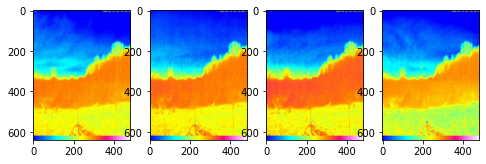

In [13]:
fig=plt.figure(figsize=(8,8))
columns = 4
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_flir[0,i-1,:,:,:].reshape(640,480,3).astype(int))
plt.show()

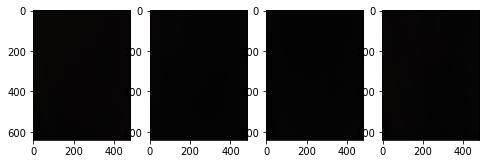

In [14]:
fig=plt.figure(figsize=(8,8))
columns = 4
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_top[0,i-1,:,:,:].reshape(640,480,3).astype(int))
plt.show()

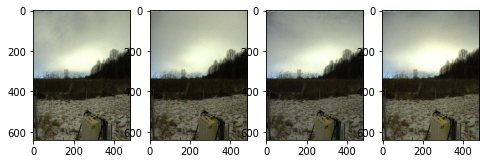

In [15]:
fig=plt.figure(figsize=(8,8))
columns = 4
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_bottom[0,i-1,:,:,:].reshape(640,480,3).astype(int))
plt.show()